In [1]:
%load_ext autoreload
%autoreload 2

In [63]:
import os
import pandas as pd
import numpy as np
import seaborn as sns

from transformers import AutoModelForCausalLM
from transformers import AutoTokenizer
from tqdm.notebook import tqdm
from numpy import array_split

from eig import compute_eig_fast
from eig.battleship import Ship, BattleshipHypothesis, Parser, Executor
from eig.battleship.program import ProgramSyntaxError

from battleship.translator import Translator
from battleship.util import convert_board_to_numeric, convert_board_to_char

# Instantiate Translator

In [3]:
MODEL_NAME = "codellama/CodeLlama-7b-hf"
tokenizer, model = Translator.load_tokenizer_and_model(MODEL_NAME)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

The BetterTransformer implementation does not support padding during training, as the fused kernels do not support attention masks. Beware that passing padded batched data during training may result in unexpected outputs. Please refer to https://huggingface.co/docs/optimum/bettertransformer/overview for more details.


In [4]:
translator = Translator(model=model, tokenizer=tokenizer)

In [5]:
completions = translator.question_to_code("How many blocks is the blue ship?")
print(completions)

['(size Blue)']


In [6]:
completions = translator.question_to_code(["What color is A1?", "What color is A2?", "What color is A3?"])
print(completions)

['(color A-1)', '(color A-2)', '(color A-3)']


# Translate the question dataset

In [47]:
DATASET_PATH = "../question_dataset/df.allBySubj.csv"
DATASET_PATH_OUTPUT = "../question_dataset/df.allBySubj.withCode.csv"

In [7]:
df = pd.read_csv(DATASET_PATH)
df

,trial,subj,bin,type,paras,para_1,para_2,para_3,full,text
0,1,7,shipsize(red),shipsize,2,2.0,NaN,NaN,How many tiles is the red ship?,How many blocks is the red ship?
1,2,7,horizontal(purple),horizontal,3,3.0,NaN,NaN,Is the purple ship horizontal?,Is the purple ship laying horizontal?
2,3,7,shipsize(red),shipsize,2,2.0,NaN,NaN,How many tiles is the red ship?,How many blocks is the red ship?
3,4,7,horizontal(blue),horizontal,1,1.0,NaN,NaN,Is the blue ship horizontal?,Is the blue ship vertical
4,5,7,shipsize(purple),shipsize,3,3.0,NaN,NaN,How many tiles is the purple ship?,How many blocks is the purple ship?
...,...,...,...,...,...,...,...,...,...,...
600,6,76,shipsize(purple),shipsize,3,3.0,NaN,NaN,How many tiles is the purple ship?,how big is the purple ship?
601,7,76,shipsize(blue),shipsize,1,1.0,NaN,NaN,How many tiles is the blue ship?,how big is the blue ship
602,8,76,shipsize(blue),shipsize,1,1.0,NaN,NaN,How many tiles is the blue ship?,how big is the blue ship?
603,9,76,shipsize(blue),shipsize,1,1.0,NaN,NaN,How many tiles is the blue ship?,how big is the blue boat


In [8]:
batch_size = 16
completions = [translator.question_to_code(df_chunk["text"]) for df_chunk in tqdm(array_split(df, len(df) // batch_size))]

/home/ubuntu/battleship/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


  0%|          | 0/37 [00:00<?, ?it/s]

In [11]:
# flatten completions and add to df
df["code"] = [completion for chunk in completions for completion in chunk]
df.to_csv(DATASET_PATH_OUTPUT, index=False)

In [12]:
df

,trial,subj,bin,type,paras,para_1,para_2,para_3,full,text,code
0,1,7,shipsize(red),shipsize,2,2.0,NaN,NaN,How many tiles is the red ship?,How many blocks is the red ship?,(size Red)
1,2,7,horizontal(purple),horizontal,3,3.0,NaN,NaN,Is the purple ship horizontal?,Is the purple ship laying horizontal?,(== (orient Purple) H)
2,3,7,shipsize(red),shipsize,2,2.0,NaN,NaN,How many tiles is the red ship?,How many blocks is the red ship?,(size Red)
3,4,7,horizontal(blue),horizontal,1,1.0,NaN,NaN,Is the blue ship horizontal?,Is the blue ship vertical,(== (orient Blue) V)
4,5,7,shipsize(purple),shipsize,3,3.0,NaN,NaN,How many tiles is the purple ship?,How many blocks is the purple ship?,(size Purple)
...,...,...,...,...,...,...,...,...,...,...,...
600,6,76,shipsize(purple),shipsize,3,3.0,NaN,NaN,How many tiles is the purple ship?,how big is the purple ship?,(size Purple)
601,7,76,shipsize(blue),shipsize,1,1.0,NaN,NaN,How many tiles is the blue ship?,how big is the blue ship,(size Blue)
602,8,76,shipsize(blue),shipsize,1,1.0,NaN,NaN,How many tiles is the blue ship?,how big is the blue ship?,(size Blue)
603,9,76,shipsize(blue),shipsize,1,1.0,NaN,NaN,How many tiles is the blue ship?,how big is the blue boat,(size Blue)


# Compute EIG scores

In [54]:
def compute_score(trial_id, code):

    # Load the game board
    board_path = os.path.join("../question_dataset", "contexts", f"board_{trial_id}.txt")

    # Convert to numpy array
    board = pd.read_csv(board_path, header=None).values.astype(str)
    board = convert_board_to_numeric(board)

    try:
        score = compute_eig_fast(code, board, grid_size=6, ship_labels=[1, 2, 3], ship_sizes=[2, 3, 4], orientations=['V', 'H'])
    except ProgramSyntaxError:
        score = 0
    except RuntimeError:
        score = 0

    return score

In [55]:
compute_score(trial_id=1, code="(size Red)")

1.3607754019025267

In [59]:
for i, row in tqdm(df.iterrows(), total=len(df)):
    df.loc[i, "score"] = compute_score(trial_id=row["trial"], code=row["code"])

  0%|          | 0/605 [00:00<?, ?it/s]

/tmp/ipykernel_2111/2619508599.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1.3607754019025267' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[i, "score"] = compute_score(trial_id=row["trial"], code=row["code"])


<Axes: xlabel='score', ylabel='Count'>

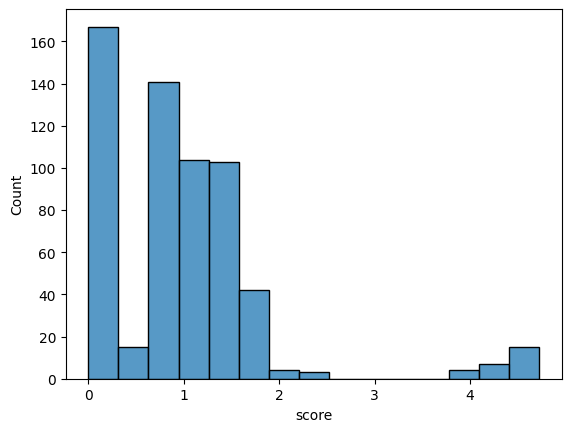

In [66]:
# Distribution of scores
sns.histplot(df["score"])

In [62]:
df.to_csv(DATASET_PATH_OUTPUT, index=False)

In [69]:
df.query("score > 2.0")

,trial,subj,bin,type,paras,para_1,para_2,para_3,full,text,code,score
66,1,17,topleft(red),topleft,2,2.0,NaN,NaN,At what location is the top left part of the r...,Where is the start of the red ship?,(topleft (coloredTiles Red)),4.669496
68,3,17,topleft(purple),topleft,3,3.0,NaN,NaN,At what location is the top left part of the p...,What are the coordinates of the topmost purple...,(topleft (coloredTiles Purple)),4.619552
225,4,51,topleft(purple),topleft,3,3.0,NaN,NaN,At what location is the top left part of the p...,Which is the first square with the purple ship...,(topleft (coloredTiles Purple)),4.620629
226,5,51,topleft(red),topleft,2,2.0,NaN,NaN,At what location is the top left part of the r...,Which is the first square with the red ship lo...,(topleft (coloredTiles Red)),4.663079
227,6,51,topleft(red),topleft,2,2.0,NaN,NaN,At what location is the top left part of the r...,Which is the first square with the red ship lo...,(topleft (coloredTiles Red)),4.726875
231,11,51,topleft(red),topleft,2,2.0,NaN,NaN,At what location is the top left part of the r...,Which is the first square with the red ship in...,(topleft (coloredTiles Red)),3.884286
232,12,51,topleft(blue),topleft,1,1.0,NaN,NaN,At what location is the top left part of the b...,Which is the first square with the blue ship i...,(topleft (coloredTiles Blue)),4.164905
233,13,51,topleft(purple),topleft,3,3.0,NaN,NaN,At what location is the top left part of the p...,Which is the first square with the purple ship...,(topleft (coloredTiles Purple)),3.994077
234,14,51,topleft(red),topleft,2,2.0,NaN,NaN,At what location is the top left part of the r...,Which is the first square with the red ship lo...,(topleft (coloredTiles Red)),4.002896
235,15,51,topleft(red),topleft,2,2.0,NaN,NaN,At what location is the top left part of the r...,Which is the first square with the red ship lo...,(topleft (coloredTiles Red)),4.181366
